# Get data

In [1]:
import requests
import pandas as pd
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')

In [45]:
#get table from Wikipedia
df_raw = pd.read_html("https://en.wikipedia.org/wiki/List_of_prime_ministers_of_the_United_Kingdom_by_birthplace")[1]

#select only ministers from 1900
df = df_raw.iloc[30:]

In [46]:
#clean data
replace_birth = {"Chorlton-on-Medlock, Lancashire,": "Chorlton-on-Medlock, Manchester", 
                "Lossiemouth, Morayshire": "Lossiemouth, Moray",
                "Putney, Surrey" : "Putney, London",
                "Huddersfield, West Riding of Yorkshire": "Huddersfield, West Yorkshire",
                "St Helier, Surrey": "St Helier, London"}
for key, value in replace_birth.items():
    df["Birthplace"] = df["Birthplace"].str.replace(key, value)
    
replace_names = {"H. H. Asquith": "Herbert Asquith", "Boris Johnson[3]": "Boris Johnson" }
for key, value in replace_names.items():
    df["Name"] = df["Name"].str.replace(key, value)
    
#TODO fix issue with replacing special characters
df.loc[df["Name"]=="Boris Johnson[3]", "Name"] = "Boris Johnson"

df["Country"] = df["Country"].str.replace("New Brunswick colony, modern day Canada", "Canada")
df["Location"] = df["Birthplace"] + ", " + df["Country"]

In [47]:
# get coordinates for region using Nominatim API
app = Nominatim(user_agent="mapping_projects")

geodata = {"lat": [], "lon": []}
for location in df["Location"]:
    loc_data = app.geocode(location).raw
    geodata["lat"].append(loc_data["lat"])
    geodata["lon"].append(loc_data["lon"])

df["lat"] = geodata["lat"]
df["lon"] = geodata["lon"]

In [48]:
## get party details from different wikipedia page
party= pd.read_html("https://simple.wikipedia.org/wiki/List_of_prime_ministers_of_the_United_Kingdom")[0]
party["Name"] = party["Name"].str.replace("Marquess of Salisbury", "Robert Gascoyne-Cecil").str.replace(
    "Andrew Bonar Law", "Bonar Law")

# join party
df = pd.merge(df, party[["Name", "Political party"]].drop_duplicates(),left_on="Name", right_on="Name", how='left')

In [50]:
#save clean data
df.to_csv("uk-prime-ministers-birthplaces.csv")
df

,Name,Term,Birthplace,Country,Location,lat,lon,Political party
0,Robert Gascoyne-Cecil,1885 to 1886 1886 to 1892 1895 to 1902,"Hatfield, Hertfordshire",England,"Hatfield, Hertfordshire, England",51.7634675,-0.2258741,Conservative
1,Arthur Balfour,1902 to 1905,"Whittingehame, East Lothian",Scotland,"Whittingehame, East Lothian, Scotland",55.9538818,-2.6415654,Conservative
2,Henry Campbell-Bannerman,1905 to 1908,"Kelvinside, Glasgow",Scotland,"Kelvinside, Glasgow, Scotland",55.8830888,-4.3027842,Liberal
3,Herbert Asquith,1908 to 1916,"Morley, West Riding of Yorkshire",England,"Morley, West Riding of Yorkshire, England",53.7384053,-0.492155,Liberal
4,David Lloyd George,1916 to 1922,"Chorlton-on-Medlock, Manchester",England,"Chorlton-on-Medlock, Manchester, England",53.4654282,-2.227277,Liberal
5,Bonar Law,1922 to 1923,"Rexton, Kent County",Canada,"Rexton, Kent County, Canada",46.641481,-64.8645487,Conservative
6,Ramsay MacDonald,1924 1929 to 1935,"Lossiemouth, Moray",Scotland,"Lossiemouth, Moray, Scotland",57.7220766,-3.2814625,Labour
7,Stanley Baldwin,1924 to 1929 1935 to 1937,"Bewdley, Worcestershire",England,"Bewdley, Worcestershire, England",52.3754763,-2.3162408,Conservative
8,Neville Chamberlain,1937 to 1940,"Edgbaston, Birmingham",England,"Edgbaston, Birmingham, England",52.4603261,-1.9179098,Conservative
9,Winston Churchill,1940 to 1945 1951 to 1955,"Blenheim, Oxfordshire",England,"Blenheim, Oxfordshire, England",51.84674295,-1.3765989216471315,Conservative


# Mapping

In [2]:
df = pd.read_csv("uk-prime-ministers-birthplaces.csv")

In [6]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

#load shapefile
fp = "uk_regions.geojson"
regions_map = gpd.GeoDataFrame.from_file(fp)

#load world map
world_map = gpd.GeoDataFrame.from_file("world_countries.geojson")

#regions_map.to_crs(epsg=4326).plot()

In [55]:
#prepare dataset
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
geo_df = gpd.GeoDataFrame(df, 
                          crs = crs, 
                          geometry = geometry)
geo_df.head()

,Unnamed: 0,Name,Term,Birthplace,Country,Location,lat,lon,Political party,geometry
0,0,Robert Gascoyne-Cecil,1885 to 1886 1886 to 1892 1895 to 1902,"Hatfield, Hertfordshire",England,"Hatfield, Hertfordshire, England",51.763467,-0.225874,Conservative,POINT (-0.22587 51.76347)
1,1,Arthur Balfour,1902 to 1905,"Whittingehame, East Lothian",Scotland,"Whittingehame, East Lothian, Scotland",55.953882,-2.641565,Conservative,POINT (-2.64157 55.95388)
2,2,Henry Campbell-Bannerman,1905 to 1908,"Kelvinside, Glasgow",Scotland,"Kelvinside, Glasgow, Scotland",55.883089,-4.302784,Liberal,POINT (-4.30278 55.88309)
3,3,Herbert Asquith,1908 to 1916,"Morley, West Riding of Yorkshire",England,"Morley, West Riding of Yorkshire, England",53.738405,-0.492155,Liberal,POINT (-0.49216 53.73841)
4,4,David Lloyd George,1916 to 1922,"Chorlton-on-Medlock, Manchester",England,"Chorlton-on-Medlock, Manchester, England",53.465428,-2.227277,Liberal,POINT (-2.22728 53.46543)


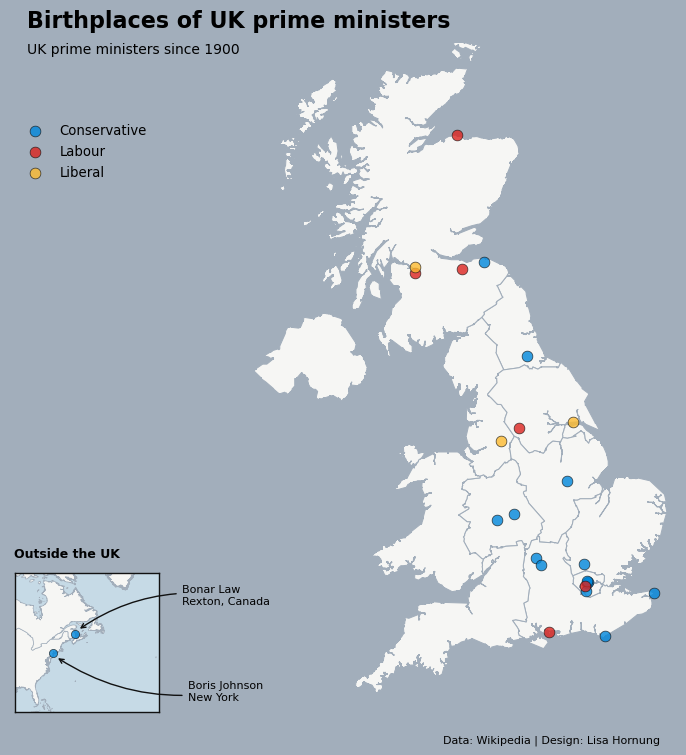

In [154]:
fig, ax = plt.subplots(figsize = (13,13))

#party colours
pointsPalette = {'Conservative': '#0087DC', 'Liberal': '#FDBB30', 'Labour': '#DC241f'}

### MAPS
#### UK
ax = plt.subplot(122)
regions_map.to_crs(epsg=4326).plot(ax=ax, color='#f6f6f4', edgecolor='#A2AEBB', linewidth=0.75)
df_uk = geo_df[~geo_df["Name"].isin(["Boris Johnson", "Bonar Law"])]

for ctype, data in df_uk.groupby('Political party'):
    color = pointsPalette[ctype]
    label = ctype
    data.plot(color=color,
              ax=ax,
              label=label,
              markersize=60,
             edgecolor='#111111',
             linewidth=0.5,
             alpha=0.8)
ax.axis('off')
ax.set_xlim(-9, 2)
ax.set_ylim(49.5, 59)
fig.set_facecolor("#A2AEBB")

#### world
ax1 = plt.subplot(6,6,27)
world_map.to_crs(epsg=4326).plot(ax=ax1, color='#f6f6f4', edgecolor='#A2AEBB', linewidth=0.5)
df_us = geo_df[geo_df["Name"].isin(["Boris Johnson", "Bonar Law"])]

ax1.set_xlim(-90, -30)
ax1.set_ylim(23, 65)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
for pos in ["bottom", "left", "right", "top"]:
    ax1.spines[pos].set(color="#111111", linewidth=1)
    
for ctype, data in df_us.groupby('Political party'):
    color = pointsPalette[ctype]
    label = ctype
    data.plot(color=color,
              ax=ax1,
              label=label,
              markersize=35,
             edgecolor='#111111',
             linewidth=0.5,
             alpha=0.8)  
ax1.set_facecolor("#C6DAE6")
ax1.set_title("Outside the UK", fontsize=9, x=0.36, y=1.05, fontweight='bold')

#Title and annotations
plt.figtext(0.4,0.77,'Birthplaces of UK prime ministers', fontsize = 16, weight = 'bold', color='black')
plt.figtext(0.4,0.75,'UK prime ministers since 1900', fontsize = 10, weight = 'regular', color='black')

plt.figtext(0.72,0.22,'Data: Wikipedia | Design: Lisa Hornung', fontsize = 8, weight = 'regular', color='black')

# ==========
#legend
L = ax.legend(ncol=1, frameon=False, loc='upper left',bbox_to_anchor=(-0.46,0.9))
plt.setp(L.texts, fontsize=9.5)

### Annotations
#arrow style
kw = dict(arrowstyle="->", color="#111111")

y = geo_df[geo_df["Name"]=="Boris Johnson"]["lat"]
x = geo_df[geo_df["Name"]=="Boris Johnson"]["lon"]
ax1.annotate('Boris Johnson\nNew York', xy=(x+1, y-1), xycoords='data', xytext=(95, -25), textcoords='offset points', 
                   fontsize=8, ha='left', va='center', annotation_clip=False,
                    arrowprops=dict(**kw, connectionstyle="arc3,rad=-.2", clip_on=False))
y = geo_df[geo_df["Name"]=="Bonar Law"]["lat"]
x = geo_df[geo_df["Name"]=="Bonar Law"]["lon"]
ax1.annotate('Bonar Law\nRexton, Canada', xy=(x+1, y+1), xycoords='data', xytext=(75, 25), textcoords='offset points', 
                   fontsize=8, ha='left', va='center', annotation_clip=False,
                    arrowprops=dict(**kw, connectionstyle="arc3,rad=.2", clip_on=False))

#save
plt.savefig("birthplaces-uk-prime-ministers.png", dpi=300)

#save
plt.savefig("birthplaces-uk-prime-ministers.svg", dpi=300)